# [IUM] Dokumentacja wstępna
**Autorzy:**  
Gustaw Malinowski (324872), Kacper Straszak (325234), Aleksandra Szymańska (318733)  
**Data:** 24.11.2024 r.

---

## Oryginalna treść zadania
**Zadanie 10:**  
“Jakiś czas temu wprowadziliśmy konta premium, które uwalniają użytkowników od słuchania reklam. Nie są one jednak jeszcze zbyt popularne – czy możemy się dowiedzieć, które osoby są bardziej skłonne do zakupu takiego konta?”

---

## Analiza z perspektywy Biznesowej

### Opis problemu biznesowego
Naszym celem jest określenie i lepsze zrozumienie profilu osoby skłonnej do zakupu konta premium w oparciu o dane o użytkownikach, ich sesjach użytkowania, artystach, utworach oraz sposobie ich przechowywania zbieranych przez serwis. Na tej podstawie firma będzie mogła podjąć decyzję o strategiach marketingowych skutecznych przy nakłanianiu do zakupu kont premium (personalizacji reklam oraz oferty) i zwiększyć zysk płynący z tego typu oferowanych usług.

---

### Założenia
- Ponieważ klient nie ponosi kosztów, uznajemy, że zwrot z inwestycji w stosunku do kosztów zawsze będzie nieskończony.
- Klient nie dysponuje istniejącym rozwiązaniem, które musielibyśmy "pokonać".
- Model nie musi być interpretowalny, ponieważ klient nie ma możliwości wpływania na zachowania użytkownika wpływające na zakup konta premium, takie jak średni czas słuchania muzyki na sesję.
- Zakładamy zdroworozsądkowe ograniczenia dotyczące prędkości obliczeń (czas obliczeń dla pojedynczego użytkownika nie powinien być zauważalny).

---

### Wymagania klienta
Od strony zastosowań biznesowych klient nie ma jasno sprecyzowanych wymagań. Oczekuje jedynie rozwiązania, które umożliwi mu dostosowanie rekomendacji.  

**Główne wymagania:**
- Dostarczenie gotowego rozwiązania maksymalnie do 17.01.2025.
- Rozwiązanie w postaci mikroserwisu umożliwiającego łatwe wykorzystanie modelu w produkcji.
- Dostarczenie dwóch modeli oraz porównanie ich wyników.
- Wykonanie eksperymentu A/B porównującego dwa modele.

---

### Proponowane biznesowe kryteria sukcesu
Rozwiązanie pozwoli klientowi zwiększyć liczbę zakupów kont premium poprzez precyzyjniejsze targetowanie reklam, zamiast dotychczasowego szerokiego serwowania ich do wszystkich użytkowników.

---

## Analiza z perspektywy modelowania

### Zadanie Modelowania

#### Analiza zadania
Aby zrealizować zadanie biznesowe polegające na określeniu użytkowników skłonnych do zakupu konta premium, definiujemy problem jako klasyfikację – czy użytkownik kupił konto premium, czy nie. Celem jest stworzenie modelu klasyfikacyjnego, który na podstawie danych o użytkownikach pozwala przewidzieć, czy dany użytkownik jest skłonny do zakupu konta premium.

---

#### Analityczne kryterium sukcesu
Model będzie miał większą dokładność niż najprostszy model bazowy. Za cel przyjmujemy dokładność na poziomie 60%.

---

#### Analityczne miary jakości modelu
W trakcie modelowania planujemy wykorzystać: 
1. Macierz Pomyłek  
2. Precyzję modelu  
3. Dokładność klasyfikacji  
4. Wartość F1  

---

### Analiza Danych

#### Dane dostarczone przez klienta
Klient dostarczył nam następujące dane:
- Ulubione gatunki muzyczne użytkowników.
- Miejsce zamieszkania użytkowników.
- Logi interakcji użytkowników z serwisem.
- Baza artystów z uwzględnieniem ich stylów muzycznych.
- Baza utworów wraz z ich charakterystyką i typem przechowywania.

---

#### Dostępne i wygenerowane atrybuty
Na podstawie dostarczonych danych zdefiniowaliśmy następujące atrybuty:
- Ilość wysłuchanych piosenek
- Średnia ilość wysłuchanych piosenek w sesji
- Ilość sesji
- Skip rate na sesje
- Czas słuchania w serwisie
- Czas słuchania w miesiącu
- Średni czas słuchania dzienny
- Czas słuchania w jednej sesji
- Ilość polubionych piosenek na wysłuchane

---

#### Liczba próbek

In [ ]:
#%pip install pandas
#%pip install numpy
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = 'content/artists.jsonl'
artists = pd.read_json(file_path, lines=True, encoding='utf-8')
file_path = 'content/sessions.jsonl'
sessions = pd.read_json(file_path, lines=True, encoding='utf-8')
file_path = 'content/track_storage.jsonl'
track_storage = pd.read_json(file_path, lines=True, encoding='utf-8')
file_path = 'content/tracks.jsonl'
tracks = pd.read_json(file_path, lines=True, encoding='utf-8')
file_path = 'content/users.jsonl'
users = pd.read_json(file_path, lines=True, encoding='utf-8')

data = ['artists', 'sessions', 'track_storage', 'tracks', 'users']

for variable in data:
	dataset = globals()[variable]
	print(f"\nAnalyzing {variable}")
	print(f"Number of samples: {dataset.shape[0]}")
	print(f"Number of atributes: {dataset.shape[1]}")
	print(f"Included information: {list(dataset.columns)}")


Analyzing artists
Number of samples: 27650
Included information: ['id', 'name', 'genres']

Analyzing sessions
Number of samples: 1453169
Included information: ['timestamp', 'user_id', 'track_id', 'event_type', 'session_id']

Analyzing track_storage
Number of samples: 129648
Included information: ['track_id', 'storage_class', 'daily_cost']

Analyzing tracks
Number of samples: 129648
Included information: ['id', 'artist_id', 'name', 'popularity', 'duration_ms', 'explicit', 'release_date', 'danceability', 'energy', 'key', 'mode', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

Analyzing users
Number of samples: 3000
Included information: ['user_id', 'name', 'city', 'street', 'favourite_genres', 'premium_user']


---

#### Jakość danych
**Powtórzenia wartości**  

In [114]:
for variable in data:
	dataset = globals()[variable]
	if variable == 'artists':
		dataset['genres'] = dataset['genres'].apply(lambda x: str(x) if isinstance(x, list) else x)
	elif variable == 'users':
		dataset['favourite_genres'] = dataset['favourite_genres'].apply(lambda x: str(x) if isinstance(x, list) else x)
	duplicated = dataset.duplicated().sum()
	print(f"\nAnalyzing {variable}")
	print(f"Duplicated entries: {duplicated}")


Analyzing artists
Duplicated entries: 0

Analyzing sessions
Duplicated entries: 0

Analyzing track_storage
Duplicated entries: 0

Analyzing tracks
Duplicated entries: 0

Analyzing users
Duplicated entries: 0



**Brakujące wartości**

In [115]:
for variable in data:
	dataset = globals()[variable]
	dataset.replace("", np.nan, inplace=True)
	print(f"\n\nAnalyzing {variable}")
	null = dataset.isnull().sum()
	print(f"NULL values: {null.sum()}")
	print(null)
	print(f"\nNULL values: {null[null > 0].index.tolist()}")



Analyzing artists
NULL values: 0
id        0
name      0
genres    0
dtype: int64

NULL values: []


Analyzing sessions
NULL values: 192781
timestamp          0
user_id            0
track_id      192781
event_type         0
session_id         0
dtype: int64

NULL values: ['track_id']


Analyzing track_storage
NULL values: 0
track_id         0
storage_class    0
daily_cost       0
dtype: int64

NULL values: []


Analyzing tracks
NULL values: 103718
id                       0
artist_id                0
name                     0
popularity               0
duration_ms              0
explicit                 0
release_date             0
danceability             0
energy                   0
key                      0
mode                103718
loudness                 0
speechiness              0
acousticness             0
instrumentalness         0
liveness                 0
valence                  0
tempo                    0
time_signature           0
dtype: int64

NULL values: ['mode

---

#### Reprezentatywność atrybutów
*(Sekcja do uzupełnienia)*

In [ ]:
file_path = 'content/artists.jsonl'
artists = pd.read_json(file_path, lines=True, encoding='utf-8')

---

#### Informatywność atrybutów
*(Sekcja do uzupełnienia)*

In [116]:
for column in artists.columns:
    artists['genres'] = artists['genres'].apply(lambda x: str(x) if isinstance(x, list) else x)
    unique_values = artists[column].nunique()
    print(f"Column '{column}' has {unique_values} unique values.")

Column 'id' has 27650 unique values.
Column 'name' has 27542 unique values.
Column 'genres' has 13704 unique values.


In [ ]:
file_path = 'content/artists.jsonl'
artists = pd.read_json(file_path, lines=True, encoding='utf-8')

file_path = 'content/users.jsonl'
with open(file_path, 'r', encoding='utf-8') as file:
    users = [json.loads(line) for line in file]

genre_counter = {}
for genres in artists['genres']:
    for genre in genres:
        genre_counter[genre] = genre_counter.get(genre, 0) + 1

user_counter = {}
for user in users:
    for genre in user.get('favourite_genres', []):
        if genre not in user_counter:
            user_counter[genre] = [0, 0]  # [total_users, premium_users]
        user_counter[genre][0] += 1
        if user.get('premium_user', False):
            user_counter[genre][1] += 1


In [ ]:
file_path = 'content/users.jsonl'

with open(file_path, 'r', encoding='utf-8') as file:
    users = [json.loads(line) for line in file]

genre_counter = {}
for genres in artists['genres']:
    for genre in genres:
        genre_counter[genre] = genre_counter.get(genre, 0) + 1

user_counter = {}
for user in users:
    for genre in user.get('favourite_genres', []):
        if genre not in user_counter:
            user_counter[genre] = [0, 0]  # [total_users, premium_users]
        user_counter[genre][0] += 1
        if user.get('premium_user', False):
            user_counter[genre][1] += 1


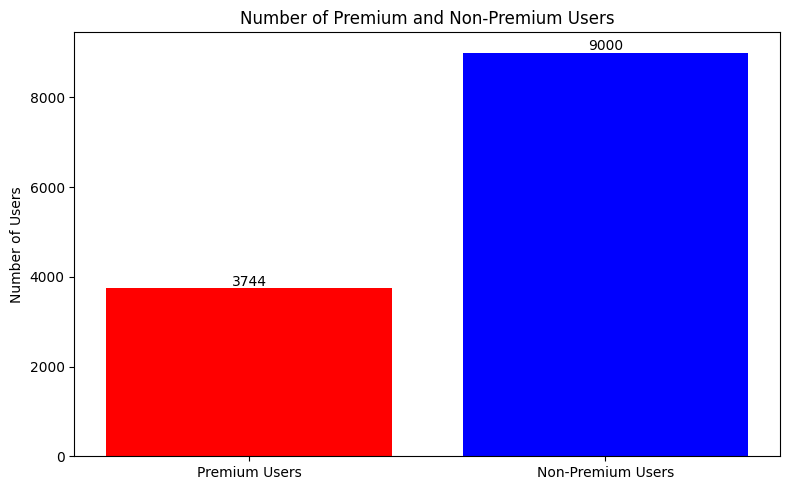

In [118]:
total_premium_users = sum(value[1] for value in user_counter.values())
total_non_premium_users = sum(value[0] for value in user_counter.values())

# Przygotuj dane do wykresu
categories = ['Premium Users', 'Non-Premium Users']
user_counts = [total_premium_users, total_non_premium_users]

# Rysowanie wykresu
plt.figure(figsize=(8, 5))
plt.bar(categories, user_counts, color=['red', 'blue'])

# Dodanie opisu osi i tytułu
plt.ylabel('Number of Users')
plt.title('Number of Premium and Non-Premium Users')

# Wyświetlenie wartości na słupkach
for i, count in enumerate(user_counts):
    plt.text(i, count + 50, str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()


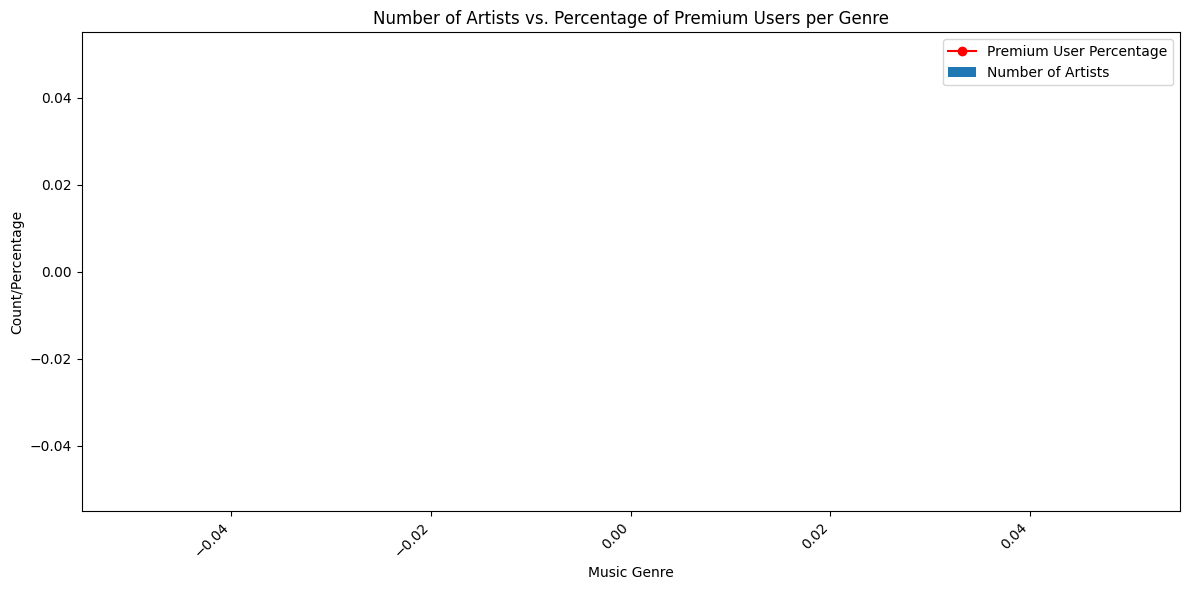

In [127]:
for genre, counts in user_counter.items():
    total_users, premium_users = counts
    user_counter[genre] = [premium_users, premium_users / total_users]

genres = list(genre_counter.keys())
gg = genres.copy()
num_bands = list(genre_counter.values())
premium_percentage = []
for genre in gg:
  if genre in user_counter:
    premium_percentage.append(user_counter[genre][1] * 100)
  else:
    num_bands.pop(genres.index(genre))
    genres.remove(genre)

plt.figure(figsize=(12, 6))
plt.bar(genres, num_bands, label='Number of Artists')
plt.plot(genres, premium_percentage, marker='o', color='red', label='Premium User Percentage')

plt.xlabel('Music Genre')
plt.ylabel('Count/Percentage')
plt.title('Number of Artists vs. Percentage of Premium Users per Genre')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
print()

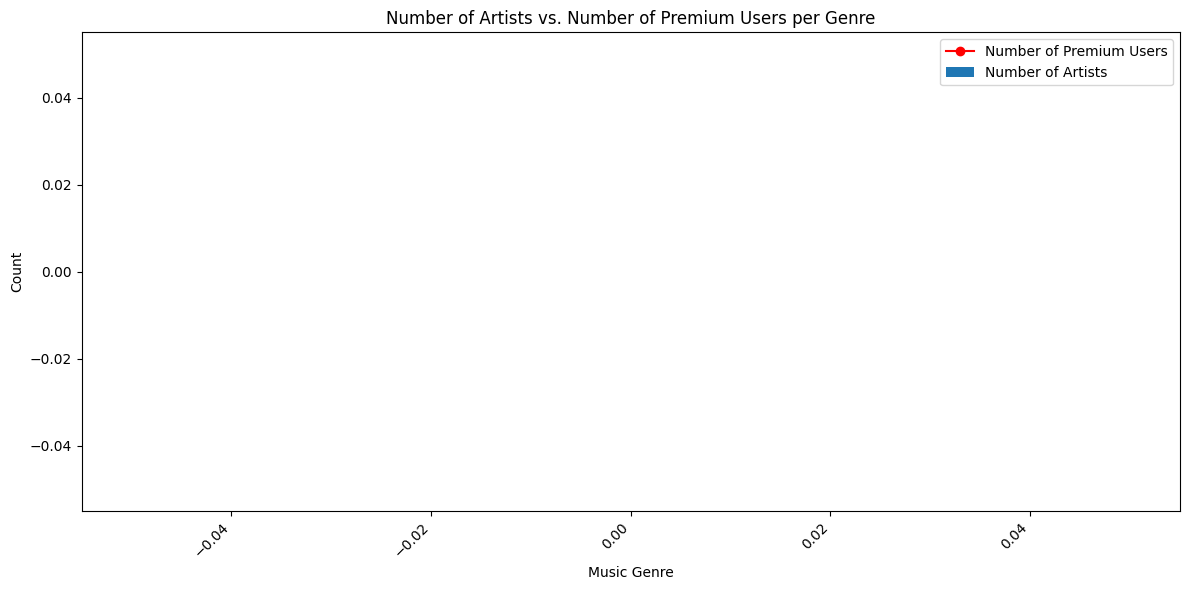

In [120]:
premium_users = [user_counter[genre][0] for genre in genres]
plt.figure(figsize=(12, 6))
plt.bar(genres, num_bands, label='Number of Artists')
plt.plot(genres, premium_users, marker='o', color='red', label='Number of Premium Users')

plt.xlabel('Music Genre')
plt.ylabel('Count')
plt.title('Number of Artists vs. Number of Premium Users per Genre')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

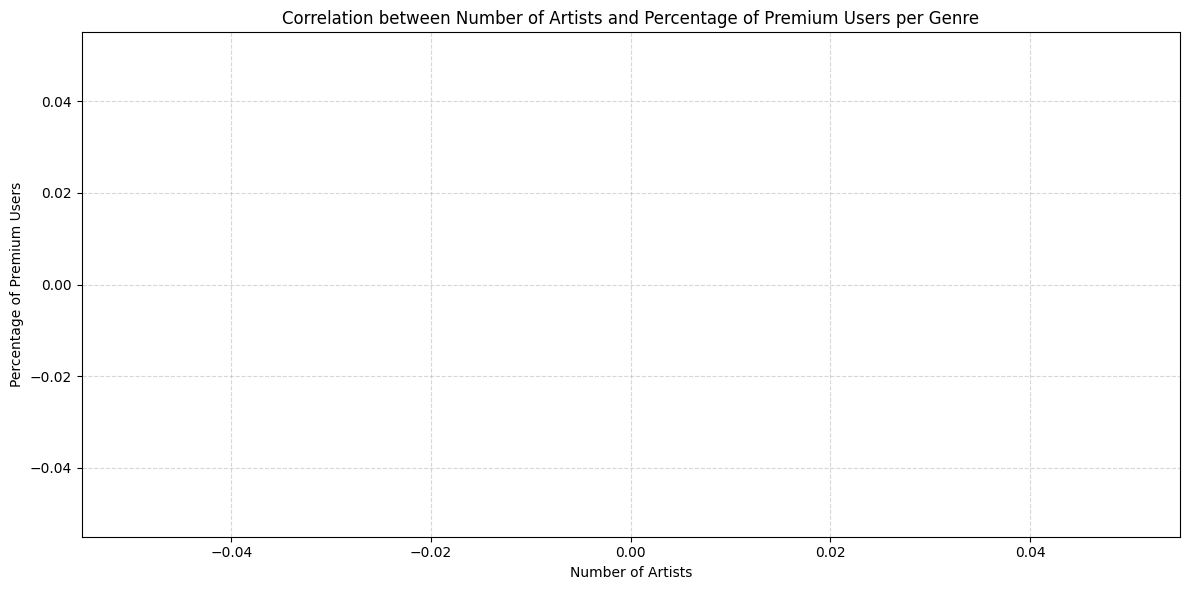

In [121]:
plt.figure(figsize=(12, 6))
plt.scatter(num_bands, premium_percentage, color='orange', alpha=0.7)

for i, genre in enumerate(genres):
    if genre in user_counter:
        plt.text(num_bands[i], premium_percentage[i], genre, fontsize=6, ha='right', va='bottom')

plt.xlabel('Number of Artists')
plt.ylabel('Percentage of Premium Users')
plt.title('Correlation between Number of Artists and Percentage of Premium Users per Genre')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [122]:
#raczej nieprzydatne ale fajnie wygląda
%pip install folium
%pip install geopy
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim

cities = {}
for user in users_dict:
  city = user.get('city')
  if city not in cities:
    cities[city] = [cities.get(city, 0) + 1, 1 if user.get('premium_user') else 0]
  else:
    cities[city][0] += 1
    cities[city][1] += 1 if user.get('premium_user') else 0

geolocator = Nominatim(user_agent="geoapi")

locations = []
for city, users in cities.items():
    location = geolocator.geocode(city + ", Poland")
    if location:
        locations.append((location.latitude, location.longitude, users[0]))

m = folium.Map(location=[52.237049, 21.017532], zoom_start=6)  # Centrum Polski

heat_data = [(lat, lon, count) for lat, lon, count in locations]
HeatMap(heat_data).add_to(m)
# m.save("poland_heatmap.html")

m


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


<Figure size 1000x500 with 0 Axes>

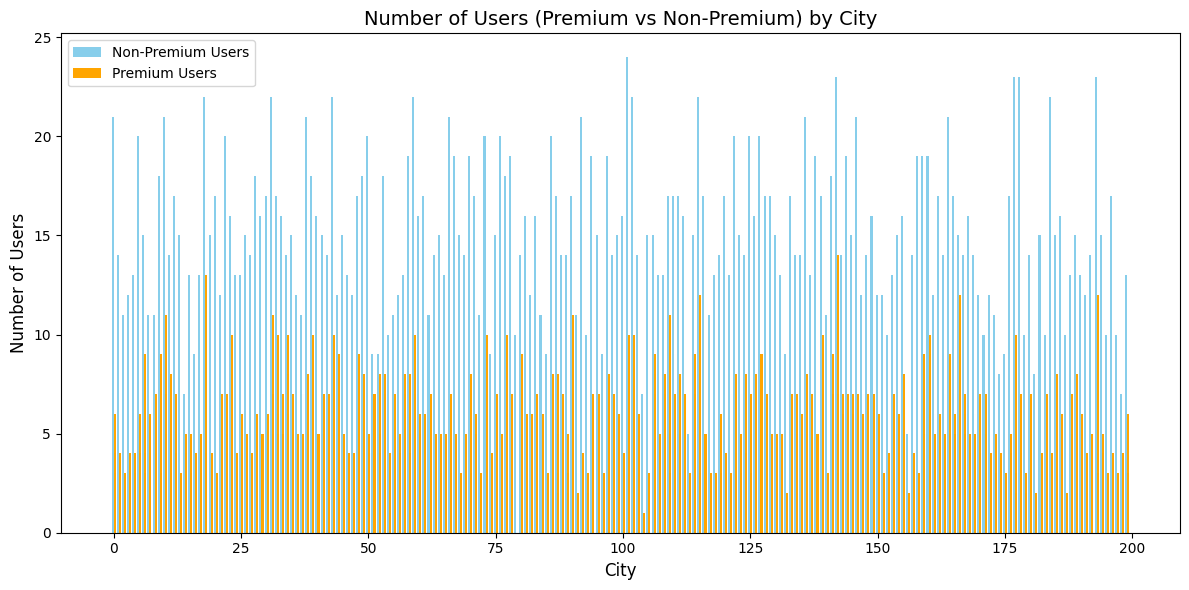

In [123]:
plt.figure(figsize=(10, 5))
keys = list(cities.keys())
values = [value[0] for value in cities.values()]
premium = [value[1] for value in cities.values()]


x = np.arange(len(keys))
bar_width = 0.4

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width / 2, values, width=bar_width, color='skyblue', label='Non-Premium Users')
plt.bar(x + bar_width / 2, premium, width=bar_width, color='orange', label='Premium Users')
plt.xlabel('City', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.title('Number of Users (Premium vs Non-Premium) by City', fontsize=14)

# plt.xticks(x, keys, rotation=90, ha='right', fontsize=10)
plt.legend()

plt.tight_layout()
plt.show()
